In [6]:
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim


from PIL import Image
from torchvision import models, datasets, transforms, utils
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
import time
from PIL import Image
import io
#from google.colab import files
#from IPython.display import Image


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
def grayscale_to_rgb(tensor):
    if tensor.shape[0] == 1:
        return tensor.repeat(3, 1, 1)
    return tensor

preprocess_train_transforms = transforms.Compose([
    transforms.Resize((256)),
    transforms.RandomRotation(5),
    transforms.RandomHorizontalFlip(0.5),
    transforms.CenterCrop(224),
    transforms.RandomCrop(224, padding=10),
    transforms.ToTensor(),
    transforms.Lambda(grayscale_to_rgb),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


preprocess_test_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = datasets.CIFAR100(root='./cifar100', train=True, download=True, transform=preprocess_train_transforms)
test_dataset = datasets.CIFAR100(root='./cifar100', train=False, transform=preprocess_test_transforms)

# dataset = datasets.Caltech101('caltech101', download=True, transform=preprocess)
# generator = torch.Generator().manual_seed(42)
# train_data, test_data, unused = data.random_split(dataset, [7677, 1000, 0], generator=generator)
# train_loader = data.DataLoader(train_data, batch_size=15, shuffle=True, num_workers=os.cpu_count())
# test_loader = data.DataLoader(test_data, batch_size=15, shuffle=False, num_workers=os.cpu_count())

Files already downloaded and verified


In [4]:
class VGG19(nn.Sequential):
    def __init__(self):
        super().__init__()

        self.first =  nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

        self.after = nn.AdaptiveAvgPool2d(7)

        self.last =  nn.Sequential(
        nn.Linear(512*7*7, 4096),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(4096, 1000),
        )

        self.initialize_weights()
    def initialize_weights(self):
        for m in self.modules():
            if(isinstance(m, nn.Conv2d)):
                torch.nn.init.kaiming_normal_(m.weight)

    def forward(self, x):
        x = self.first(x)
        x = self.after(x)
        h = x.view(x.shape[0], -1)
        x = self.last(h)
        return x

In [5]:
learning_rate = 0.0001
num_epochs = 120
size_of_batch= 128
torch.cuda.empty_cache()

network = VGG19()
# save untrained model
torch.save(network.state_dict(), 'untrained.pth')

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(network.parameters(), lr=learning_rate)

scheduler = ReduceLROnPlateau(optimizer, factor=0.5, patience=5, verbose=True)


if torch.cuda.is_available():
    from torch.cuda.amp import autocast, GradScaler


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=size_of_batch,
                                          shuffle=True, num_workers=2, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=size_of_batch,
                                         shuffle=False, num_workers=2, pin_memory=True)

def train(num_epochs):
    train_avg_loss = []
    test_avg_loss = []
    test_accuracy = []

    network.to(device)
    scaler = GradScaler(enabled=torch.cuda.is_available())
    network.train()
    network.eval()
    for i in tqdm(range(num_epochs)):

        train_losses = []
        test_losses = []

        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)

            optimizer.zero_grad()

            with autocast(enabled=torch.cuda.is_available()):
              pred = network(x)
              loss = criterion(pred, y)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_losses.append(loss.item())

        train_avg_loss.append(np.array(train_losses).mean())
        scheduler.step(np.array(test_losses).mean())


        with torch.no_grad():
            correct = 0

            for x, y in test_loader:

                x = x.to(device)
                y = y.to(device)

                pred = network(x)
                loss = criterion(pred, y)


                test_losses.append(loss.item())

                y_pred = pred.argmax(dim=-1)
                correct += (y_pred == y).sum().item()

            test_avg_loss.append(np.mean(test_losses))
            accuracy = correct / len(test_dataset) * 100
            test_accuracy.append(accuracy)



    
    network.to('cpu')


    return [train_avg_loss, test_avg_loss, test_accuracy]

In [6]:
train_avg_loss, test_avg_loss, test_accuracy = train(num_epochs)

  0%|          | 0/120 [00:00<?, ?it/s]/tmp/ipykernel_32/3241203840.py:56: RuntimeWarning: Mean of empty slice.
  scheduler.step(np.array(test_losses).mean())
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  4%|▍         | 5/120 [43:15<16:35:01, 519.14s/it]

Epoch 00006: reducing learning rate of group 0 to 5.0000e-05.


  9%|▉         | 11/120 [1:35:11<15:43:14, 519.22s/it]

Epoch 00012: reducing learning rate of group 0 to 2.5000e-05.


 14%|█▍        | 17/120 [2:27:04<14:50:45, 518.89s/it]

Epoch 00018: reducing learning rate of group 0 to 1.2500e-05.


 19%|█▉        | 23/120 [3:18:56<13:58:27, 518.63s/it]

Epoch 00024: reducing learning rate of group 0 to 6.2500e-06.


 24%|██▍       | 29/120 [4:10:48<13:06:34, 518.63s/it]

Epoch 00030: reducing learning rate of group 0 to 3.1250e-06.


 29%|██▉       | 35/120 [5:02:38<12:14:24, 518.40s/it]

Epoch 00036: reducing learning rate of group 0 to 1.5625e-06.


 34%|███▍      | 41/120 [5:54:29<11:22:32, 518.39s/it]

Epoch 00042: reducing learning rate of group 0 to 7.8125e-07.


 39%|███▉      | 47/120 [6:46:19<10:30:37, 518.33s/it]

Epoch 00048: reducing learning rate of group 0 to 3.9063e-07.


 44%|████▍     | 53/120 [7:38:07<9:38:32, 518.09s/it] 

Epoch 00054: reducing learning rate of group 0 to 1.9531e-07.


 49%|████▉     | 59/120 [8:29:56<8:46:45, 518.13s/it]

Epoch 00060: reducing learning rate of group 0 to 9.7656e-08.


 54%|█████▍    | 65/120 [9:21:44<7:54:53, 518.06s/it]

Epoch 00066: reducing learning rate of group 0 to 4.8828e-08.


 59%|█████▉    | 71/120 [10:13:32<7:03:07, 518.11s/it]

Epoch 00072: reducing learning rate of group 0 to 2.4414e-08.


 64%|██████▍   | 77/120 [11:05:20<6:11:13, 517.99s/it]

Epoch 00078: reducing learning rate of group 0 to 1.2207e-08.


100%|██████████| 120/120 [17:16:37<00:00, 518.31s/it]  


In [7]:
torch.save(network.state_dict(), 'trained.pth')

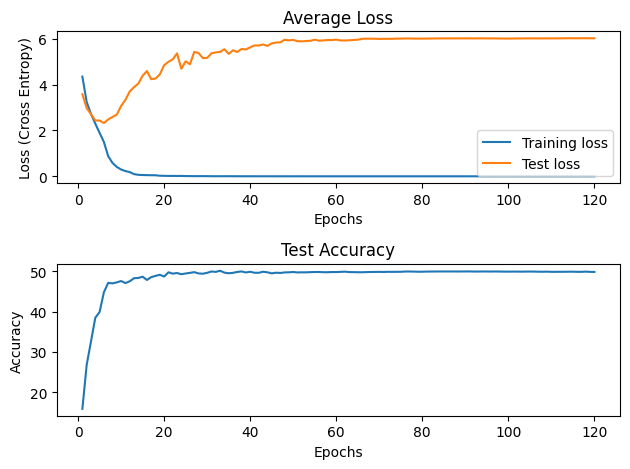

In [9]:
fig, axs = plt.subplots(2, 1)

axs[0].set_title('Average Loss')
axs[0].plot(range(1, num_epochs + 1), train_avg_loss, label='Training loss')
axs[0].plot(range(1, num_epochs + 1), test_avg_loss, label='Test loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss (Cross Entropy)')
axs[0].legend()

axs[1].set_title('Test Accuracy')
axs[1].plot(range(1, num_epochs + 1), test_accuracy)
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')

plt.tight_layout()
plt.show()

In [ ]:
#uploaded = files.upload()

In [21]:
# pretrained models
#model = models.get_model('vgg19', weights='VGG19_Weights.DEFAULT').to(device)
# model = models.get_model('resnet50', weights='ResNet50_Weights.DEFAULT').to(device)

# our model
model = network
#model.load_state_dict(torch.load('trained.pth'))
model = model.to(device)

In [23]:
content_image = Image.open("/notebooks/cat.jpg")
style_image = Image.open("/notebooks/van-gogh-la-nuit-etoilee-1.jpg")

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

tensor_to_img = transforms.Compose([
    transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255], std=[1/0.229, 1/0.224, 1/0.255]),
    transforms.Lambda(lambda x: x.clamp(0, 255)),
    transforms.ToPILImage(),
])


In [24]:
# our model
content_layer = model.first[22]  # conv4_2
style_layers = [model.first[1],  # conv1_1
                model.first[6],  # conv2_1
                model.first[11],  # conv3_1
                model.first[20],  # conv4_1
                model.first[29]]  # conv5_1

In [ ]:
# define layers used for style transfer
# pretrained vgg19
content_layer = model.features[22]  # conv4_2
style_layers = [model.features[1],  # conv1_1
                model.features[6],  # conv2_1
                model.features[11],  # conv3_1
                model.features[20],  # conv4_1
                model.features[29]]  # conv5_1

In [ ]:
# resnet50
content_layer = model.layer3[5].relu
style_layers = [model.layer1[2].relu,
                model.layer2[3].relu,
                model.layer3[5].relu,
                model.layer4[2].relu]

In [25]:

# disable gradient computation for model parameters
model.requires_grad_(False)

# add hooks to save the activations of intermediate layers
# on call to forward()
content_activation = [None]
def content_hook(model, input, output):
    content_activation[0] = output
content_layer.register_forward_hook(content_hook)

style_activation = [None] * len(style_layers)
def get_style_hook(i):  # hook for i-th style layer
    def style_hook(model, input, output):
        style_activation[i] = output
    return style_hook
for i, layer in enumerate(style_layers):
    layer.register_forward_hook(get_style_hook(i))

In [26]:
content_weight = 1e-2
style_weight = 1
style_transfer_learning_rate = .02
num_steps = 5000

def style_transfer_loss(x, content_target, style_target):
    total_squared_error = nn.MSELoss(reduction='sum')
    model(x.unsqueeze(0))

    content_loss = total_squared_error(content_activation[0].squeeze(0), content_target)

    style_loss = 0
    for activation, target in zip(style_activation, style_target):
        activation = activation.squeeze(0)
        style_loss += total_squared_error(gram_matrix(activation), target)
    style_loss /= len(style_layers)
    return content_weight * content_loss + style_weight * style_loss, content_loss, style_loss

def gram_matrix(activation):
    shape = activation.shape
    a = activation.view(shape[0], shape[1] * shape[2])  # flatten pixels to one dimension
    return a @ a.T / a.size()[0]  # (scaled) scalar product of the pixel values for each pair of channels

def style_transfer(content_image, style_image):
    content_tensor = preprocess(content_image)
    style_tensor = preprocess(style_image)
    batch = torch.stack((content_tensor, style_tensor))
    batch = batch.to(device)
    model(batch)
    content_target = content_activation[0][0]
    style_target = [gram_matrix(activation[1]) for activation in style_activation]

    # initialize using the content image to save time
    generated = content_tensor.detach().clone().to(device).requires_grad_(True)
    #generated = torch.randn(content_tensor.shape, requires_grad=True, device=device)

    optimizer = torch.optim.Adam([generated], lr=style_transfer_learning_rate)

    losses = []
    content_losses = []
    style_losses = []
    for i in tqdm(range(num_steps)):
        loss, content_loss, style_loss = style_transfer_loss(generated, content_target, style_target)
        losses.append(loss.detach().cpu())
        content_losses.append(content_loss.detach().cpu())
        style_losses.append(style_loss.detach().cpu())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return generated.detach().cpu(), losses, content_losses, style_losses

100%|██████████| 5000/5000 [01:01<00:00, 80.92it/s]


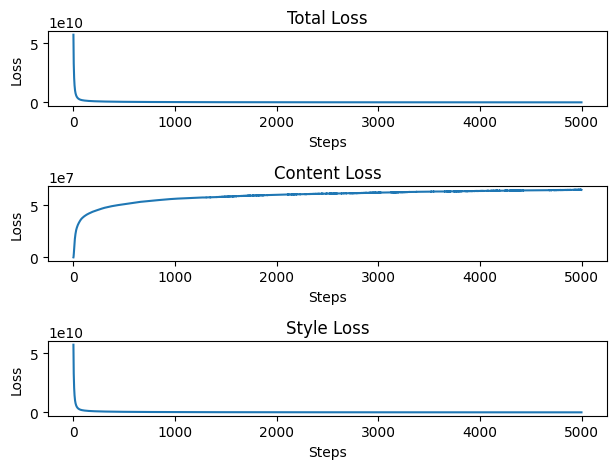

In [27]:
generated, losses, content_losses, style_losses = style_transfer(content_image, style_image)
fig, axs = plt.subplots(3, 1)

axs[0].set_title("Total Loss")
axs[0].plot(losses)
axs[0].set_xlabel("Steps")
axs[0].set_ylabel("Loss")

axs[1].set_title("Content Loss")
axs[1].plot(content_losses)
axs[1].set_xlabel("Steps")
axs[1].set_ylabel("Loss")

axs[2].set_title("Style Loss")
axs[2].plot(style_losses)
axs[2].set_xlabel("Steps")
axs[2].set_ylabel("Loss")

plt.tight_layout()
plt.show()

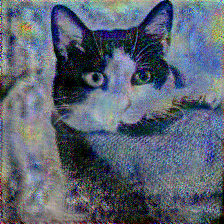

In [28]:
image = tensor_to_img(generated)
image